## Model Based Submodular Selection
Author: Jacob Schreiber <jmschreiber91@gmail.com>


Submodular selection is the task of identifying a representative subset of samples from a large set, and apricot focuses on the use of these algorithms to identify a good subset of data that can be used for the purpose of training machine learning models. However, submodular functions can also be coupled with a trained machine learning model and a feature attribution algorithm in order to identify the subset of features that the machine learning model thinks are the most important for training. 

In order to understand how this works, let's review the feature based submodular algorithm that's implemented in apricot. These functions greedily add samples to the growing subset that utilize a diversity of features. The equation that the feature based functions optimize is as follows:

\begin{equation}
f(X) = \sum\limits_{u \in U} w_{u} \phi_{u} \left( \sum\limits_{x \in X} m_{u}(x_{u}) \right)
\end{equation}

In this equation, $U$ is the set of features, or dimensions, of a sample, and $u$ refers to a specific feature. $X$ refers to the original data set that we are selecting from and $x$ refers to a single sample from that data set. $w$ is a vector of weights that indicate how important each feature is, with $w_{u}$ being a scalar referring to how important feature $u$ is. Frequently these weights are uniform. $\phi$ refers to a set of saturating functions, such as $sqrt(X)$ or $log(X + 1)$, that have diminishing returns the larger X gets. 

The default implementation in apricot for $m_{u}$ is the identify function $m_{u}(x_{u}) = x_{u}$, meaning that a sample will have the most gain when it has a high feature value in a feature that is not well represented with high values in the already included samples. What if, instead of using the raw feature value, we used the feature ~attribution~ as determined by some attribution algorithm? This would give us a subset of samples that gave a diversity of importanes. 

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import shap

from sklearn.linear_model import LogisticRegressionCV
from shap import LinearExplainer
from apricot import FeatureBasedSelection

Populating the interactive namespace from numpy and matplotlib


Let's start off with creating two clusters of data and seeing what happens when we use a feature based function off of them natively.

In [46]:
X = numpy.concatenate([numpy.random.normal((7, 8), 1, size=(100, 2)), 
                       numpy.random.normal((10, 5), 1, size=(100, 2))])

y = numpy.concatenate([numpy.zeros(100), numpy.ones(100)])

Xi, yi = FeatureBasedSelection(20).fit_transform(X, y)

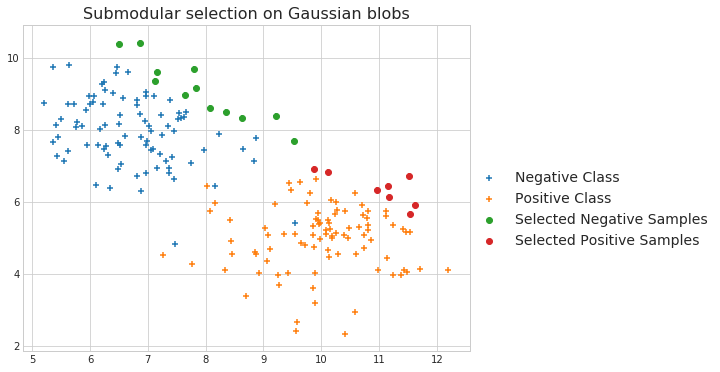

In [47]:
plt.figure(figsize=(8, 6))
plt.title("Submodular selection on Gaussian blobs", fontsize=16)
plt.scatter(X[:100, 0], X[:100, 1], marker='+', label='Negative Class')
plt.scatter(X[100:, 0], X[100:, 1], marker='+', label='Positive Class')
plt.scatter(Xi[yi == 0, 0], Xi[yi == 0, 1], label='Selected Negative Samples')
plt.scatter(Xi[yi == 1, 0], Xi[yi == 1, 1], label="Selected Positive Samples")

plt.legend(fontsize=14, loc=(1, 0.3))
plt.show()

That's unfortunate. It looks like the selected samples are just those with the highest feature values. As you un a diagonal line with slope x = -y down from the top right corner of the plot, it selected the first 20 points that it hits. This is a downside of using a feature based function natively.

Well, our goal here was not to select on the feature naively, but rather to identify features that a trained machine learning model thought were important. However, this term "important" can have two meanings. It can be the samples that are thhe most obvious samples from one or another class, perhaps the most representative, or it can be those that are on the boundary. Let's look at the first case first. In order to calculate feature importances we will use the package shap.

The first thing to do is to train our model. In our case let's train a logistic regression model.

In [48]:
model = LogisticRegressionCV().fit(X, y)

Now we need to gt the attributions. These values sum up to the final prediction and atribute to each feature the importance of that measurement.

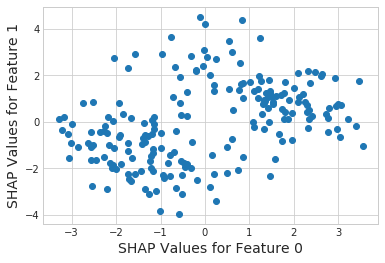

In [62]:
X_shap = LinearExplainer(model, X, nsamples=10000).shap_values(X)

plt.scatter(X_shap[:,0], X_shap[:,1])
plt.xlabel("SHAP Values for Feature 0", fontsize=14)
plt.ylabel("SHAP Values for Feature 1", fontsize=14)
plt.show()

Unfortunately these values correspond to the log odds and so can be negative when they are predicting the negative class. Essentially this corresponds to running a logit function on the probabilities, and so we can undo that by running an expit function on the features. However, if we ran expit on the feature attributions themselves, the smallest resulting values would correspond to those features that previously were responsible for strong swings towards the negative class. In order to account for magnitude corresponding to importance, we have to first take the absolute value of the data.

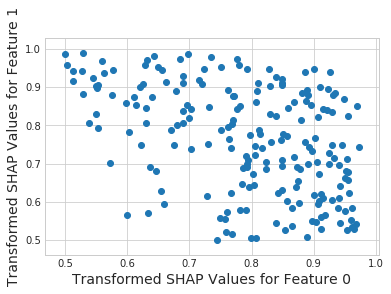

In [63]:
from scipy.special import expit

X_shap = expit(numpy.abs(X_shap))

plt.scatter(X_shap[:,0], X_shap[:,1])
plt.xlabel("Transformed SHAP Values for Feature 0", fontsize=14)
plt.ylabel("Transformed SHAP Values for Feature 1", fontsize=14)
plt.show()

In this transformed space we will still be taking samples that are hit first by a line from the top right, but these correspond to important samples in the original space. Let's take a look at that.

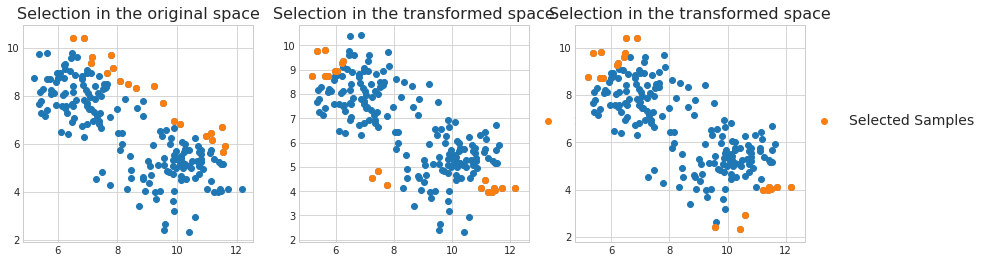

In [64]:
Xi1 = FeatureBasedSelection(20).fit_transform(X)

selector = FeatureBasedSelection(20)
selector.fit_transform(X_shap)
Xi2 = X[selector.indices]

y_pred = model.predict_proba(X).max(axis=1)
idx = numpy.argsort(y_pred)[::-1]

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Selection in the original space", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi1[:,0], Xi1[:,1], label="Selected Samples")

plt.subplot(132)
plt.title("Selection in the transformed space", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi2[:,0], Xi2[:,1], label="Selected Samples")
plt.legend(fontsize=14, loc=(1, 0.5))

plt.subplot(133)
plt.title("Selection in the transformed space", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[idx[:20], 0], X[idx[:20], 1], label="Selected Samples")
plt.legend(fontsize=14, loc=(1, 0.5))
plt.show()

This shows how one can do the transformation when importance is defined as those points that are most cleanly defined as one class or another. In the case of Gaussian blobs it may be trivial to figure out what those samples are, but in a large feature space that is more complicated it may not be as easy to do.

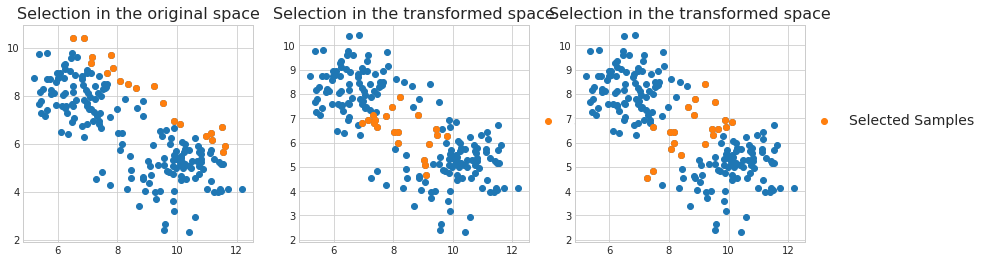

In [67]:
X_shap = LinearExplainer(model, X, nsamples=1000).shap_values(X)
X_shap = expit(numpy.abs(1. / X_shap))


Xi1 = FeatureBasedSelection(20).fit_transform(X)

selector = FeatureBasedSelection(20)
selector.fit_transform(X_shap)
Xi2 = X[selector.indices]

y_pred = model.predict_proba(X).min(axis=1)
idx = numpy.argsort(y_pred)[::-1]

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Selection in the original space", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi1[:,0], Xi1[:,1], label="Selected Samples")

plt.subplot(132)
plt.title("Selection in the transformed space", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi2[:,0], Xi2[:,1], label="Selected Samples")
plt.legend(fontsize=14, loc=(1, 0.5))

plt.subplot(133)
plt.title("Selection in the transformed space", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[idx[:20], 0], X[idx[:20], 1], label="Selected Samples")
plt.legend(fontsize=14, loc=(1, 0.5))
plt.show()

This results in a greedy selection of samples that are near the learned decision boundary. These are the points that the model is the least confident in, and so would likely be good to identify when one is error checking their model and would like to know what's going on. 

In [310]:
X = numpy.concatenate([numpy.random.uniform((4, 5), (8, 6.1), size=(200, 2)),
                       numpy.random.uniform((4, 5), (5.7, 8), size=(200, 2)),
                       numpy.random.uniform((4, 8), (8, 9), size=(200, 2)),
                       numpy.random.uniform(6, 8, size=(200, 2))])

y = numpy.concatenate([numpy.zeros(400), numpy.ones(400)])

(5, 9)

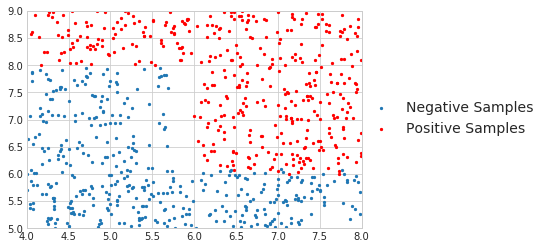

In [313]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=5, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', s=5, label="Positive Samples")
plt.legend(fontsize=14, loc=(1, 0.4))
plt.xlim(4, 8)
plt.ylim(5, 9)

In [307]:
from sklearn.svm import SVC
from shap import KernelExplainer

model = SVC(probability=True).fit(X, y)
explainer = KernelExplainer(model.predict_proba, X)
X_shap = explainer.shap_values(X)
X_shap = X_shap[1] - X_shap[0]
X_shap = expit(numpy.abs(1. / X_shap))

Xi1 = FeatureBasedSelection(25).fit_transform(X)

selector = FeatureBasedSelection(25)
selector.fit_transform(X_shap)
Xi2 = X[selector.indices]

y_pred = model.predict_proba(X).min(axis=1)
idx = numpy.argsort(y_pred)[::-1]


xx, yy = np.meshgrid(np.arange(4, 8.1, 0.1), np.arange(5, 9.1, 0.1))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

100%|██████████| 800/800 [00:08<00:00, 92.70it/s]


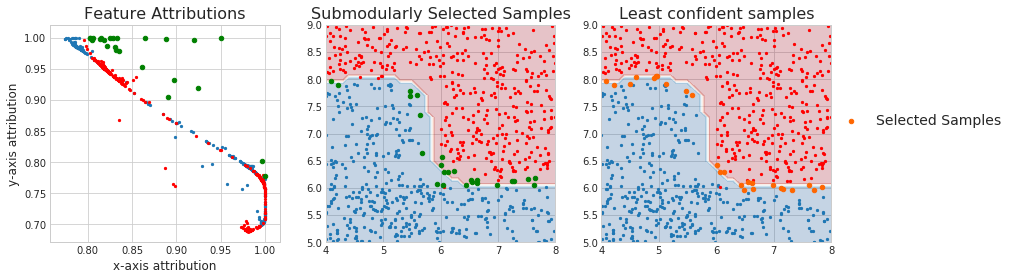

In [309]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Feature Attributions", fontsize=16)
plt.scatter(X_shap[y == 0, 0], X_shap[y == 0, 1], s=5)
plt.scatter(X_shap[y == 1, 0], X_shap[y == 1, 1], c='r', s=5)
plt.scatter(X_shap[selector.indices][:, 0], X_shap[selector.indices][:, 1], c='g', s=20)
plt.xlabel("x-axis attribution", fontsize=12)
plt.ylabel("y-axis attribution", fontsize=12)

plt.subplot(132)
plt.title("Submodularly Selected Samples", fontsize=16)
plt.contourf(xx, yy, Z, cmap='RdBu_r', linewidths=0.3, alpha=0.25)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', s=5)
plt.scatter(Xi2[:, 0], Xi2[:, 1], s=20, color='g', label="Selected Samples")
plt.xlim(4, 8)
plt.ylim(5, 9)

plt.subplot(133)
plt.title("Least confident samples", fontsize=16)

plt.contourf(xx, yy, Z, cmap='RdBu_r', linewidths=0.3, alpha=0.25)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', s=5)
plt.scatter(X[idx[:25], 0], X[idx[:25], 1], s=20, color='#FF6600', label="Selected Samples")
plt.xlim(4, 8)
plt.ylim(5, 9)

plt.legend(fontsize=14, loc=(1, 0.5))
plt.show()